In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from terrain_sim import TerrainSimulator

from sar_sim_mesh import SARSimulator
from geom import plot_radar_trajectory_and_object, place_object_on_terrain, mesh_to_facets

In [2]:
# 1) Terrain 생성 + roughness map
terrain = TerrainSimulator(xlim=(-50, 50), ylim=(-50, 50), nx=251, ny=251, kind="hill")
terrain_mesh = terrain.build()

# 2) Object 로드 + terrain 위 배치
stl_path = "F16.stl"
obj_raw = pv.read(stl_path).triangulate()

obj_mesh = place_object_on_terrain(
    obj_mesh=obj_raw,
    height_fn=terrain.height_fn,
    xyz=(0.0, 0.0, 0.0),          # (x, y, z) 추가로 올리고 싶으면 z에 값
    rpy_deg=(0.0, 90.0, 90.0),   # roll, pitch, yaw (deg)
    rotate_about="center",
    z_offset=0.0
)

m_obj, c_obj, n_obj, a_obj = mesh_to_facets(obj_mesh)
print("obj z bounds:", obj_mesh.bounds[4], obj_mesh.bounds[5]) # [4]:min, [5]:max
print("centers object shape:", c_obj.shape)

obj z bounds: 15.0 17.954133987426758
centers object shape: (4092, 3)


In [3]:
# (옵션) 씬 확인

plotter = pv.Plotter()
plotter.add_mesh(terrain_mesh, color="tan", opacity=0.9, show_edges=False)
plotter.add_mesh(obj_mesh, color="lightgray", show_edges=False)
plotter.add_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:34569/index.html?ui=P_0x7ae2fd49bfd0_0&reconnect=auto" class="pyvi…

In [ ]:
sar = SARSimulator(
    f0=5e9, bandwidth=600e6,
    az_start=-3, az_end=3, radius=1000,
    window_type="Hanning",
    targets=c_obj, rcs=None,
    x_span=100, y_span=100,
    use_cupy=True,
    chunk_facets=10000
)

In [5]:
signal, freqs, ref_points =sar.generate_phase_history(use_farfield=True)
p_signal = sar.postprocess(signal)
print("signal shape: ", signal.shape)

sensor xyz shape:  (28304, 3)
number of antenna(pulses) / frequency: 28304 / 566
[PH] 1/28304
[PH] 2831/28304
[PH] 5661/28304
[PH] 8491/28304
[PH] 11321/28304
[PH] 14151/28304
[PH] 16981/28304
[PH] 19811/28304
[PH] 22641/28304
[PH] 25471/28304
[PH] 28301/28304
signal shape:  (28304, 566)


sensor xyz shape:  (28304, 3)


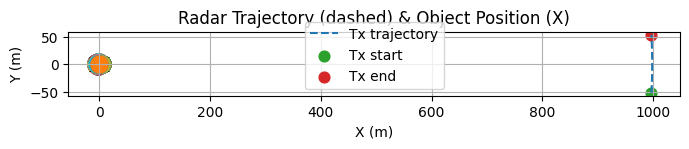

In [6]:
sensor_xyz = sar.get_sensor_positions().get()
plot_radar_trajectory_and_object(
    object_xyz=c_obj,
    tx_traj=sensor_xyz, rx_traj=sensor_xyz,
    bistatic=False,          # True로 바꾸면 Tx/Rx 둘 다 점선 표시
)

In [7]:
bp_image, xi, yi = sar.backprojection_image(signal=p_signal)


[BP] 10001/28304
[BP] 20001/28304
[BP] 28305/28304


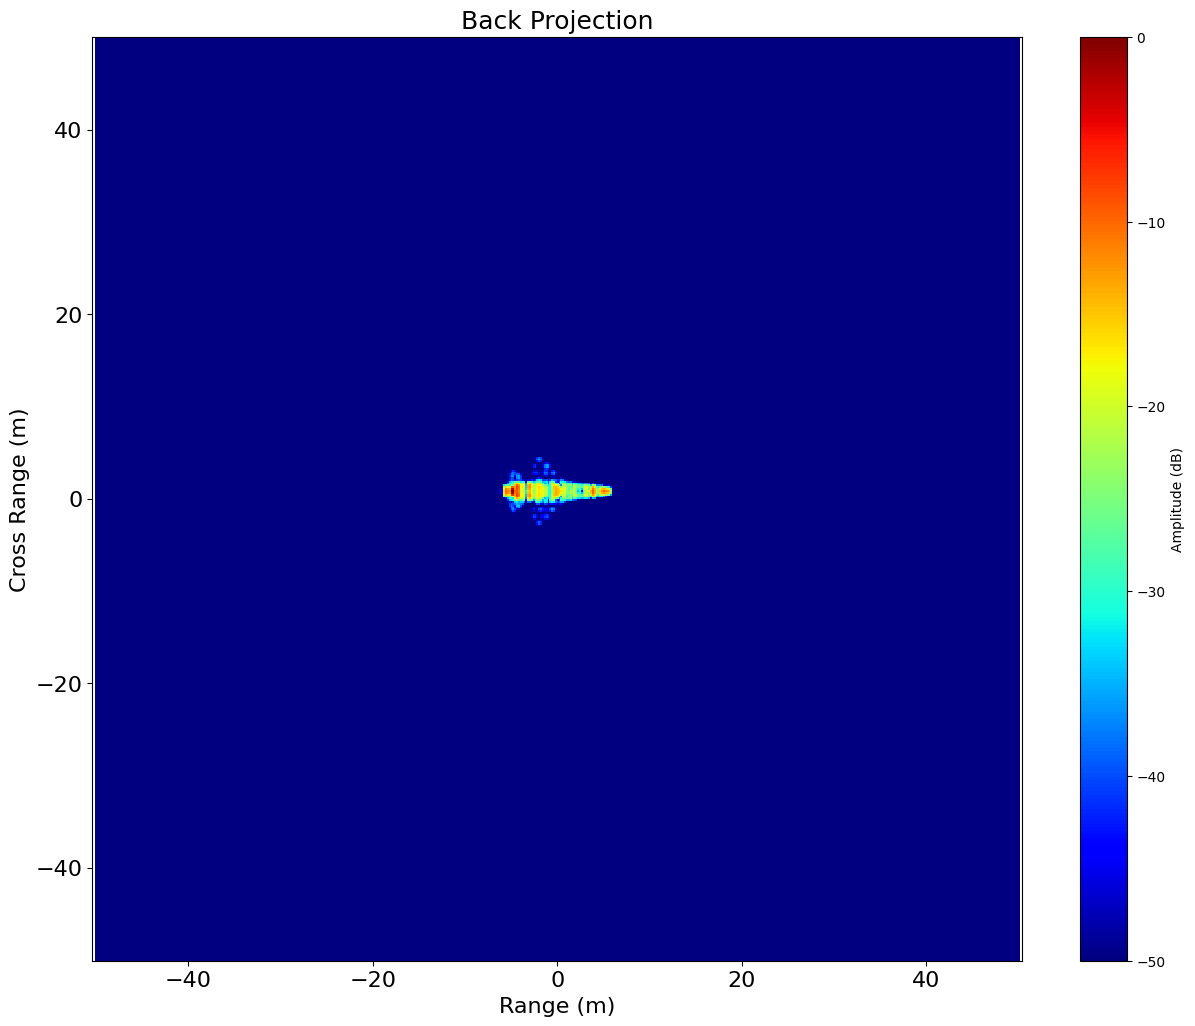

In [ ]:

dynamic_range = 50
# Set the figure size
plt.rcParams["figure.figsize"] = (15, 12)

# Plot the backprojected image
plt.figure()
plt.pcolor(xi, yi, 20 * np.log10(np.abs(bp_image) / np.max(np.abs(bp_image))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

# Set the title and labels
plt.title('Back Projection', size=18)
plt.xlabel('Range (m)', size=16)
plt.ylabel('Cross Range (m)', size=16)



# Make the axes equal
plt.axis('equal')

# Set the tick label size
plt.tick_params(labelsize=16)

# Turn on the colorbar and set the label
cbar = plt.colorbar()
cbar.set_label('Amplitude (dB)')

# Show the figure
plt.show()